# DINO-GPT4V

Neste tutorial, exploraremos como usar o DINO-GPT4-V, uma poderosa combinação de DINO e GPT-4V, para tarefas avançadas de detecção de objetos. Esse método é particularmente eficaz para identificar objetos específicos em imagens, como marcas de carros, sem a necessidade de treinamento extensivo de modelos.

## O que você aprenderá
- Como instalar e configurar as ferramentas e APIs necessárias
- Como criar um modelo de detecção em dois estágios usando o Grounding DINO e o GPT-4V
- Rotulagem automática de conjuntos de dados e treinamento de um modelo de detecção de objetos com ajuste fino

Use o seguinte comando para instalar o Autodistill junto com os conectores para Grounding DINO e GPT-4V:

In [1]:
#pip install autodistill autodistill-grounding-dino autodistill-gpt-4v

#Baseado em https://blog.roboflow.com/dino-gpt-4v/
# https://docs.autodistill.com/base_models/grounding-dino/

Verifique se você tem uma chave de API da OpenAI. Caso contrário, crie uma conta da OpenAI e emita uma chave de API. Observe que a OpenAI cobra pelas solicitações de API.

### O Autodistill usa modelos de base grandes e mais lentos para treinar modelos supervisionados pequenos e mais rápidos. Com o autodistill, você pode ir de imagens não rotuladas à inferência em um modelo personalizado em execução na borda, sem intervenção humana no meio.

In [1]:
from autodistill_gpt_4v import GPT4V #alterar a flag do modelo para um modelo indicado https://platform.openai.com/docs/deprecations, usando: gpt-4o-mini
from autodistill.detection import CaptionOntology
from autodistill_grounding_dino import GroundingDINO
from autodistill.utils import plot
from autodistill.core.composed_detection_model import ComposedDetectionModel
import supervision as sv
import cv2
from PIL import Image
import os

Importing from timm.models.layers is deprecated, please import via timm.layers


In [3]:


classes = ["mercedes", "toyota"]

DINOGPT = ComposedDetectionModel(
    detection_model=GroundingDINO(
        CaptionOntology({"car": "car"})
    ),
    classification_model= GPT4V(
        CaptionOntology({k: k for k in classes}),
        api_key="CHAVE"
    )
)

results = DINOGPT.predict('mercedes.jpeg')

plot(
    image=cv2.imread('mercedes.jpeg'),
    detections=results,
    classes=["mercedes", "toyota", "car"]
)

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)


trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: CHAVE. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

# USANDO SOMENTE O GROUNDING DINO

- https://github.com/IDEA-Research/GroundingDINO/tree/main


A técnica é apresentada no Paper: Grounding DINO: Marrying DINO with Grounded Pre-Training for Open-Set Object Detection (https://arxiv.org/abs/2303.05499)


O GROUNDING DINO permite detectar objetos em imagens com base em descrições textuais livres (ex: "um cachorro correndo no parque"), sem necessidade de treinamento específico para cada classe. Isso o torna ideal para cenários zero-shot (detecção de objetos nunca vistos durante o treinamento).

- Componentes Principais
    - Backbone de Imagem (ex: Vision Transformer - ViT):

    - Extrai características hierárquicas da imagem.

    - Herda a arquitetura do DINO, treinada de forma auto-supervisionada para capturar padrões visuais robustos.

- Backbone de Texto (ex: BERT ou CLIP):

    - Processa a descrição textual (prompt) e gera embeddings semânticos.

    - Alinha os conceitos textuais com as regiões visuais da imagem.

- Módulo de Fusão Multimodal:

    - Combina características de imagem e texto para identificar regiões relevantes.

    - Usa atenção cruzada (cross-attention) para relacionar palavras a regiões visuais.

    - Gerador de Propostas:

    - Produz caixas delimitadoras (bounding boxes) e pontuações de confiança associadas ao texto.



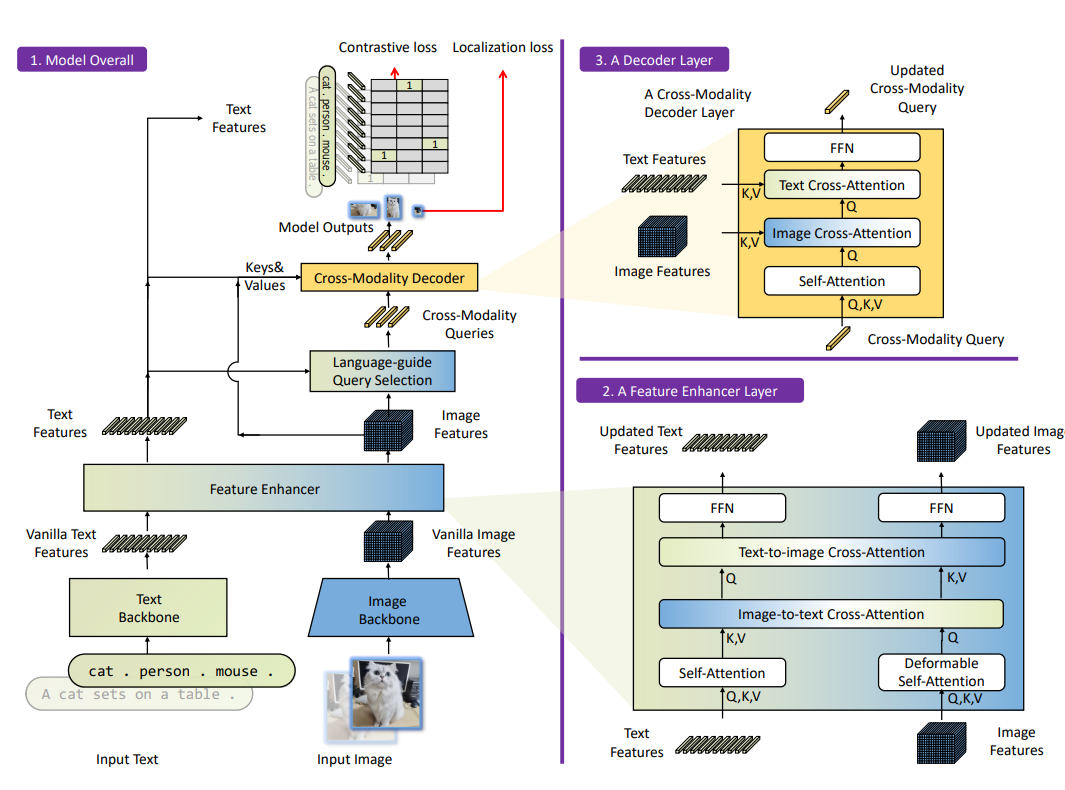

In [2]:
from groundingdino.util.inference import load_model, load_image, predict, annotate

#Na função annotate, trocar para:

"""
No arquivo inference.py do pacote groundingdino

def annotate(image_source: np.ndarray, boxes: torch.Tensor, logits: torch.Tensor, phrases: List[str]) -> np.ndarray:
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    detections = sv.Detections(xyxy=xyxy)

    labels = [
        f"{phrase} {logit:.2f}"
        for phrase, logit
        in zip(phrases, logits)
    ]
    
    annotated_frame = cv2.cvtColor(image_source, cv2.COLOR_RGB2BGR)
    annotated_frame = sv.BoxAnnotator(color_lookup = sv.ColorLookup.INDEX).annotate(scene=annotated_frame, detections=detections)
    annotated_frame = sv.LabelAnnotator(color_lookup = sv.ColorLookup.INDEX).annotate( scene=annotated_frame, detections=detections, labels=labels)
    return annotated_frame

"""

#Baixar peso wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
model = load_model("GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "pesos/groundingdino_swint_ogc.pth")
IMAGE_PATH = "mercedes.jpeg"
TEXT_PROMPT = "some car"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
cv2.imwrite("annotated_image.jpeg", annotated_frame)

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)


final text_encoder_type: bert-base-uncased


The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


True